# Querying Qwen-VL

In [ ]:
import nest_asyncio

nest_asyncio.apply()  # Run this first.

model_path = "Qwen/Qwen2.5-VL-3B-Instruct"
chat_template = "qwen2-vl"

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
What's shown here: <|vision_start|><|image_pad|><|vision_end|>?<|im_end|>
<|im_start|>assistant



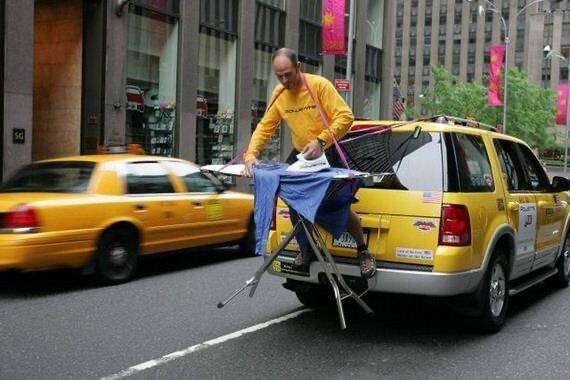

In [ ]:
# Lets create a prompt.

from io import BytesIO
import requests
from PIL import Image

from sglang.srt.entrypoints.openai.protocol import ChatCompletionRequest
from sglang.srt.conversation import chat_templates

image = Image.open(
    BytesIO(
        requests.get(
            "https://github.com/sgl-project/sglang/blob/main/test/lang/example_image.png?raw=true"
        ).content
    )
)

conv = chat_templates[chat_template].copy()
conv.append_message(conv.roles[0], f"What's shown here: {conv.image_token}?")
conv.append_message(conv.roles[1], "")
conv.image_data = [image]

print(conv.get_prompt())
image

## Query via the offline Engine API

In [ ]:
from sglang import Engine

llm = Engine(
    model_path=model_path, chat_template=chat_template, mem_fraction_static=0.8
)

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:03<00:03,  3.13s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:06<00:00,  3.27s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:06<00:00,  3.25s/it]

Capturing batches (bs=1

In [ ]:
out = llm.generate(prompt=conv.get_prompt(), image_data=[image])
print(out["text"])

In the picture, a person in a yellow shirt is hanging laundry on a clothesline attached to the back of a yellow taxi in an urban setting. There are city streets, buildings, and traffic lights visible in the background. The scene appears to be incongruous and amusing, as it shows an unusual and somewhat chaotic activity happening in a busy city environment.


## Query via the offline Engine API, but send precomputed embeddings

In [ ]:
# Compute the image embeddings using Huggingface.

from transformers import AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration

processor = AutoProcessor.from_pretrained(model_path, use_fast=True)
vision = (
    Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path).eval().visual.cuda()
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
processed_prompt = processor(
    images=[image], text=conv.get_prompt(), return_tensors="pt"
)
input_ids = processed_prompt["input_ids"][0].detach().cpu().tolist()
precomputed_embeddings = vision(
    processed_prompt["pixel_values"].cuda(), processed_prompt["image_grid_thw"].cuda()
)

mm_item = dict(
    modality="IMAGE",
    image_grid_thw=processed_prompt["image_grid_thw"],
    precomputed_embeddings=precomputed_embeddings,
)
out = llm.generate(input_ids=input_ids, image_data=[mm_item])
print(out["text"])

The image shows a scene with two yellow taxis in an urban setting. The taxi on the left has a red light on top, indicating that it may be waiting or preparing to drive. The other taxi, which is facing left, has its hatch open with some clothing or fabric hanging out. The background features high-rise buildings and city streets, suggesting this is taking place in a downtown area of a city. The presence of multiple flags on flagpoles indicates that there might be some celebration or event within the vicinity.


# Querying Llama 4 (Vision)

In [ ]:
import nest_asyncio

nest_asyncio.apply()  # Run this first.

model_path = "meta-llama/Llama-4-Scout-17B-16E-Instruct"
chat_template = "llama-4"

<|header_start|>user<|header_end|>

What's shown here: <|image|>?<|eot|><|header_start|>assistant<|header_end|>


Image size: (570, 380)


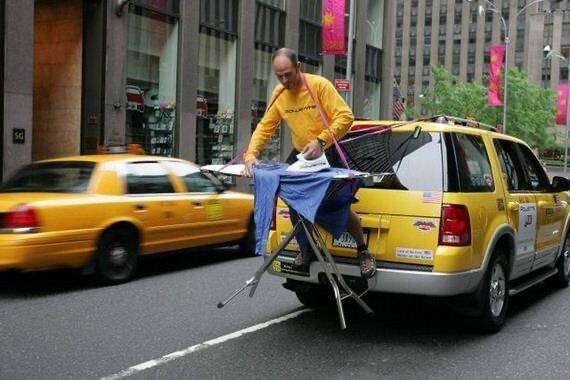

In [ ]:
# Lets create a prompt.

from io import BytesIO
import requests
from PIL import Image

from sglang.srt.entrypoints.openai.protocol import ChatCompletionRequest
from sglang.srt.conversation import chat_templates

image = Image.open(
    BytesIO(
        requests.get(
            "https://github.com/sgl-project/sglang/blob/main/test/lang/example_image.png?raw=true"
        ).content
    )
)

conv = chat_templates[chat_template].copy()
conv.append_message(conv.roles[0], f"What's shown here: {conv.image_token}?")
conv.append_message(conv.roles[1], "")
conv.image_data = [image]

print(conv.get_prompt())
print(f"Image size: {image.size}")

image

## Query via the offline Engine API

In [ ]:
from sglang.test.test_utils import is_in_ci

if not is_in_ci():
    from sglang import Engine

    llm = Engine(
        model_path=model_path,
        trust_remote_code=True,
        enable_multimodal=True,
        mem_fraction_static=0.8,
        tp_size=4,
        attention_backend="fa3",
        context_length=65536,
    )

Loading safetensors checkpoint shards:   0% Completed | 0/50 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   2% Completed | 1/50 [00:22<18:10, 22.26s/it]
Loading safetensors checkpoint shards:   4% Completed | 2/50 [00:44<17:44, 22.17s/it]
Loading safetensors checkpoint shards:   6% Completed | 3/50 [01:06<17:24, 22.22s/it]
Loading safetensors checkpoint shards:   8% Completed | 4/50 [01:28<16:55, 22.07s/it]
Loading safetensors checkpoint shards:  10% Completed | 5/50 [01:50<16:28, 21.96s/it]
Loading safetensors checkpoint shards:  12% Completed | 6/50 [02:11<15:59, 21.80s/it]
Loading safetensors checkpoint shards:  14% Completed | 7/50 [02:34<15:52, 22.14s/it]
Loading safetensors checkpoint shards:  16% Completed | 8/50 [02:54<15:05, 21.57s/it]
Loading safetensors checkpoint shards:  18% Completed | 9/50 [03:17<14:51, 21.74s/it]
Loading safetensors checkpoint shards:  20% Completed | 10/50 [03:29<12:31, 18.79s/it]
Loading safetensors checkpoint shards:  22% Completed | 11/50

Setting sliding_window_size to be attention_chunk_size: 8192Setting sliding_window_size to be attention_chunk_size: 8192



Loading safetensors checkpoint shards: 100% Completed | 50/50 [05:44<00:00,  3.43s/it]
Loading safetensors checkpoint shards: 100% Completed | 50/50 [05:44<00:00,  6.90s/it]



Setting sliding_window_size to be attention_chunk_size: 8192
Setting sliding_window_size to be attention_chunk_size: 8192


Capturing batches (bs=1 avail_mem=21.53 GB): 100%|██████████| 35/35 [00:15<00:00,  2.25it/s]  


In [ ]:
if not is_in_ci():
    out = llm.generate(prompt=conv.get_prompt(), image_data=[image])
    print(out["text"])

The image depicts a man ironing clothing on the back of a yellow SUV in a city street, with another yellow taxi passing by. The man is wearing a yellow shirt and appears to be ironing a blue shirt on a makeshift ironing board set up behind the SUV. The scene suggests that the man may be a street vendor or someone who is trying to make a living by providing ironing services to people on the go.


## Query via the offline Engine API, but send precomputed embeddings

In [ ]:
if not is_in_ci():
    # Compute the image embeddings using Huggingface.

    from transformers import AutoProcessor
    from transformers import Llama4ForConditionalGeneration

    processor = AutoProcessor.from_pretrained(model_path, use_fast=True)
    model = Llama4ForConditionalGeneration.from_pretrained(
        model_path, torch_dtype="auto"
    ).eval()
    vision = model.vision_model.cuda()
    multi_modal_projector = model.multi_modal_projector.cuda()

Loading checkpoint shards:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
if not is_in_ci():
    processed_prompt = processor(
        images=[image], text=conv.get_prompt(), return_tensors="pt"
    )
    print(f'{processed_prompt["pixel_values"].shape=}')
    input_ids = processed_prompt["input_ids"][0].detach().cpu().tolist()

    image_outputs = vision(
        processed_prompt["pixel_values"].to("cuda"), output_hidden_states=False
    )
    image_features = image_outputs.last_hidden_state
    vision_flat = image_features.view(-1, image_features.size(-1))
    precomputed_embeddings = multi_modal_projector(vision_flat)

    mm_item = dict(modality="IMAGE", precomputed_embeddings=precomputed_embeddings)
    out = llm.generate(input_ids=input_ids, image_data=[mm_item])
    print(out["text"])

processed_prompt["pixel_values"].shape=torch.Size([5, 3, 336, 336])
The image depicts a man ironing on a makeshift ironing board set up on the back of a yellow SUV, in the middle of a busy street. The man is wearing a yellow shirt and appears to be ironing a blue shirt. In the background, there are other yellow taxis and tall buildings, suggesting that the scene is set in a city, likely New York City. The overall scene is one of a person going about their daily activities in a busy urban environment.
